In [1]:
!where python

/home/andrewkc/Projects/research-project/cleanenv/bin/python
/home/andrewkc/Projects/research-project/cleanenv/bin/python


In [2]:
!pip list

Package                  Version
------------------------ -----------
asttokens                3.0.0
comm                     0.2.2
contourpy                1.3.2
cycler                   0.12.1
debugpy                  1.8.14
decorator                5.2.1
exceptiongroup           1.3.0
executing                2.2.0
filelock                 3.18.0
fonttools                4.58.4
fsspec                   2025.5.1
ipykernel                6.29.5
ipython                  8.37.0
jedi                     0.19.2
Jinja2                   3.1.6
joblib                   1.5.1
jupyter_client           8.6.3
jupyter_core             5.8.1
kiwisolver               1.4.8
MarkupSafe               3.0.2
matplotlib               3.10.3
matplotlib-inline        0.1.7
mpmath                   1.3.0
nest-asyncio             1.6.0
networkx                 3.4.2
numpy                    1.24.4
nvidia-cublas-cu12       12.6.4.1
nvidia-cuda-cupti-cu12   12.6.80
nvidia-cuda-nvrtc-cu12   12.6.77
nvidia-cuda-

In [3]:
#!pip uninstall -y numpy scipy

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.11.4
Uninstalling scipy-1.11.4:
  Successfully uninstalled scipy-1.11.4


In [4]:
#!pip install numpy==1.24.4 scipy==1.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 183.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 208.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scipy]32m1/2 [scipy]


# 0. Load Data

In [14]:
import numpy as np
import pickle
import glob
import os

folder = '/home/andrewkc/Projects/research-project/deap-dataset/data_preprocessed_python'

files = sorted(glob.glob(os.path.join(folder, 's*.dat')))

# Use lists first
all_data = []
all_labels = []

# Load and extract 'data' and 'labels' from each file
for file in files:
    with open(file, 'rb') as f:
        subject = pickle.load(f)
        all_data.append(subject['data'])     # shape: (40, 40, 8064)
        all_labels.append(subject['labels']) # shape: (40, 4)

In [15]:
# Convert to NumPy arrays                       32 x 40 = 1280
all_data = np.concatenate(all_data, axis=0)     # shape: (1280, 40, 8064)
all_labels = np.concatenate(all_labels, axis=0) # shape: (1280, 4)

# 32 personas vieron 40 videos cada una, de cada video se extrajo señales en 8064 instantes por cada uno de los 40 canales 
# (señales fisiológicas). Nosotros vamos a usar solo los primeros 32 canales de las señales como lo hace el autor del paper 
# (señales capturadas por los electrodos, es decir, señales EEG)

all_data = all_data[:, :32, :]
all_labels = all_labels[:, :2]  # (1280, 2)
print(all_data.shape)
print(all_labels)

(1280, 32, 8064)
[[1.29 1.4 ]
 [0.9  1.69]
 [0.42 1.46]
 ...
 [3.05 7.01]
 [3.99 7.17]
 [7.15 4.03]]


In [16]:
print(all_labels.shape)

(1280, 2)


# 1. Features Extractors

In [17]:
# Hyperparameters
WINDOW_SIZE  = 128
NUM_SEGMENTS = 8064 / WINDOW_SIZE
print(NUM_SEGMENTS)

63.0


## 1.1. SpatialTemporalFExtractor

In [4]:
import numpy as np
from scipy.signal import butter, lfilter
from math import log, pi, e

class SpatialTemporalFExtractor:
    def __init__(self, sampling_rate=128, window_size_sec=1):
        self.fs = sampling_rate
        self.window_size = window_size_sec * self.fs  # muestras
        self.bands = {
            'theta': (4, 8), # low high Hz
            'alpha': (8, 12),
            'beta': (12, 30),
            'gamma': (30, 50)
        }

        # Mapa espacial Geneva (matriz 9x9 como en el paper)
        # El índice de cada canal EEG en la matriz (basado en la convención Geneva del paper)
        self.channel_map = {
            0:  (0, 3),   # Fp1
            1:  (1, 3),   # AF3
            2:  (2, 2),   # F3
            3:  (2, 0),   # F7
            4:  (3, 1),   # FC5
            5:  (3, 3),   # FC1
            6:  (4, 2),   # C3
            7:  (4, 0),   # T7
            8:  (5, 1),   # CP5
            9:  (5, 3),   # CP1
            10: (6, 2),   # P3
            11: (6, 0),   # P7
            12: (7, 3),   # PO3
            13: (8, 3),   # O1
            14: (8, 4),   # Oz
            15: (6, 4),   # Pz
            16: (0, 5),   # Fp2
            17: (1, 5),   # AF4
            18: (2, 4),   # Fz
            19: (2, 6),   # F4
            20: (2, 8),   # F8
            21: (3, 7),   # FC6
            22: (3, 5),   # FC2
            23: (4, 4),   # Cz
            24: (4, 6),   # C4
            25: (4, 8),   # T8
            26: (5, 7),   # CP6
            27: (5, 5),   # CP2
            28: (6, 6),   # P4
            29: (6, 8),   # P8
            30: (7, 5),   # PO4
            31: (8, 5),   # O2
        }

        self.left_hemisphere = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
        self.right_hemisphere = [16, 17, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31]

    def bandpass_filter(self, signal, low, high, order=4):
        nyq = 0.5 * self.fs
        b, a = butter(order, [low / nyq, high / nyq], btype='band')
        return lfilter(b, a, signal)

    def differential_entropy(self, signal):
        var = np.var(signal)
        return 0.5 * np.log(2 * pi * e * var + 1e-8)  # sumamos 1e-8 para evitar log(0)

    def extract_features(self, signal_3d):
        """
        signal_3d: shape (32, 8064)  → 32 canales, 8064 muestras (60 s)
        return: list of DE-matrices por ventana [num_windows x num_bandas x 9 x 9]
        """
        channels, total_samples = signal_3d.shape
        num_windows = total_samples // self.window_size

        features = []

        for w in range(num_windows):
            start = w * self.window_size
            end = start + self.window_size
            window_data = signal_3d[:, start:end]  # shape: (32, window_size)

            band_matrices = []

            for band_name, (low, high) in self.bands.items():
                band_matrix = np.zeros((9, 9))  # matriz espacial

                for ch in range(32):
                    filtered = self.bandpass_filter(window_data[ch], low, high)
                    de = self.differential_entropy(filtered)

                    if ch in self.channel_map:
                        x, y = self.channel_map[ch]
                        band_matrix[x, y] = de

                band_matrices.append(band_matrix)

            features.append(np.stack(band_matrices))  # shape: (4, 9, 9)

        return np.array(features)  # shape: (num_windows, 4, 9, 9)

## 1.2. ConnectiveFExtractor

In [5]:
import numpy as np
from scipy.signal import butter, lfilter, hilbert
from math import log, pi, e


class ConnectiveFExtractor:
    def __init__(self, sampling_rate=128, window_size_sec=1, mode="pcc"):
        self.fs = sampling_rate
        self.window_size = window_size_sec * self.fs
        self.mode = mode.lower()
        
        # Definición de las bandas cerebrales
        self.bands = {
            'theta': (4, 8),
            'alpha': (8, 12),
            'beta': (12, 30),
            'gamma': (30, 50)
        }

        # Pares de canales simétricos (izquierdo, derecho) para la conectividad
        self.paired_channels = [
            (i, j) for i in range(32) for j in range(i+1, 32) 
        ]

    def bandpass_filter(self, signal, low, high, order=4):
        """Filtra la señal en un rango de frecuencias utilizando un filtro pasa-banda."""
        nyq = 0.5 * self.fs
        b, a = butter(order, [low / nyq, high / nyq], btype='band')
        return lfilter(b, a, signal)

    def phase_locking_value(self, signal1, signal2):
        """Calcula el Phase Locking Value (PLV) entre dos señales EEG."""
        analytic_signal_1 = hilbert(signal1)
        analytic_signal_2 = hilbert(signal2)
        phase_diff = np.angle(analytic_signal_1) - np.angle(analytic_signal_2)
        return np.abs(np.mean(np.exp(1j * phase_diff)))

    def pearson_correlation(self, signal1, signal2):
        """Calcula la correlación de Pearson entre dos señales EEG."""
        return np.corrcoef(signal1, signal2)[0, 1]

    def phase_lag_index(self, signal1, signal2):
        """Calcula el Phase Lag Index (PLI) entre dos señales EEG."""
        analytic_signal_1 = hilbert(signal1)
        analytic_signal_2 = hilbert(signal2)
        phase_diff = np.angle(analytic_signal_1) - np.angle(analytic_signal_2)
        return np.abs(np.mean(np.sign(np.sin(phase_diff))))

    def extract_pcc_features(self, signal_3d):
        """
        Extrae las características de conectividad para PCC: (num_windows, 4, 32, 32)
        """
        channels, total_samples = signal_3d.shape
        num_windows = total_samples // self.window_size

        all_features = []

        for w in range(num_windows):
            start = w * self.window_size
            end = start + self.window_size
            window_data = signal_3d[:, start:end]  

            pcc_matrix = np.zeros((32, 32))

            for band_name, (low, high) in self.bands.items():
                filtered_signals = []

                for i in range(32):
                    filtered_signal = self.bandpass_filter(window_data[i], low, high)
                    filtered_signals.append(filtered_signal)

                for i, j in self.paired_channels:
                    left_signal = filtered_signals[i]
                    right_signal = filtered_signals[j]

                    pcc_matrix[i, j] = self.pearson_correlation(left_signal, right_signal)

                    pcc_matrix[j, i] = pcc_matrix[i, j]

                pcc_matrix = (pcc_matrix + 1) / 2

                all_features.append(pcc_matrix)
        all_features_array = np.array(all_features)  
        return all_features_array.reshape(63, 4, 32, 32)  

    def extract_plv_features(self, signal_3d):
        """
        Extrae las características de conectividad para PLV: (num_windows, 4, 32, 32)
        """
        channels, total_samples = signal_3d.shape
        num_windows = total_samples // self.window_size

        all_features = []

        for w in range(num_windows):
            start = w * self.window_size
            end = start + self.window_size
            window_data = signal_3d[:, start:end]  

            plv_matrix = np.zeros((32, 32))

            for band_name, (low, high) in self.bands.items():
                filtered_signals = []

                for i in range(32):
                    filtered_signal = self.bandpass_filter(window_data[i], low, high)
                    filtered_signals.append(filtered_signal)
                for i, j in self.paired_channels:
                    left_signal = filtered_signals[i]
                    right_signal = filtered_signals[j]

                    plv_matrix[i, j] = self.phase_locking_value(left_signal, right_signal)

                    plv_matrix[j, i] = plv_matrix[i, j]

                plv_matrix = (plv_matrix + 1) / 2

                all_features.append(plv_matrix)

        
        all_features_array = np.array(all_features)  
        return all_features_array.reshape(63, 4, 32, 32) 

    def extract_pli_features(self, signal_3d):
        """
        Extrae las características de conectividad para PLI: (num_windows, 4, 32, 32)
        """
        channels, total_samples = signal_3d.shape
        num_windows = total_samples // self.window_size

        all_features = []

        for w in range(num_windows):
            start = w * self.window_size
            end = start + self.window_size
            window_data = signal_3d[:, start:end]  

            pli_matrix = np.zeros((32, 32))

            for band_name, (low, high) in self.bands.items():
                filtered_signals = []

            
                for i in range(32):
                    filtered_signal = self.bandpass_filter(window_data[i], low, high)
                    filtered_signals.append(filtered_signal)

            
                for i, j in self.paired_channels:
                    left_signal = filtered_signals[i]
                    right_signal = filtered_signals[j]

                    pli_matrix[i, j] = self.phase_lag_index(left_signal, right_signal)

                    pli_matrix[j, i] = pli_matrix[i, j]

          
                pli_matrix = (pli_matrix + 1) / 2

                all_features.append(pli_matrix)

      
        all_features_array = np.array(all_features)  
        return all_features_array.reshape(63, 4, 32, 32)

    def extract_features(self, signal_3d):
        # Extrae todas las matrices a la vez
        pcc = self.extract_pcc_features(signal_3d)
        plv = self.extract_plv_features(signal_3d)
        pli = self.extract_pli_features(signal_3d)
        return pcc, plv, pli

## 1.3. IntesityDifferenceFExtractor

In [6]:
import numpy as np
from scipy.signal import butter, lfilter
from math import log, pi, e

class IntensityDifferenceFExtractor:
    def __init__(self, sampling_rate=128, window_size_sec=1):
        self.fs = sampling_rate
        self.window_size = window_size_sec * sampling_rate

        # Bandas cerebrales
        self.bands = {
            'theta': (4, 8),
            'alpha': (8, 12),
            'beta': (12, 30),
            'gamma': (30, 50)
        }

        # Pares de canales simétricos (izquierdo, derecho)
        self.paired_channels = [
            (0, 16),   # Fp1 - Fp2
            (1, 17),   # AF3 - AF4
            (2, 19),   # F3 - F4
            (3, 20),   # F7 - F8
            (4, 21),   # FC5 - FC6
            (5, 22),   # FC1 - FC2
            (6, 24),   # C3 - C4
            (7, 25),   # T7 - T8
            (8, 26),   # CP5 - CP6
            (9, 27),   # CP1 - CP2
            (10, 28),  # P3 - P4
            (11, 29),  # P7 - P8
            (12, 30),  # PO3 - PO4
            (13, 31),  # O1 - O2
        ]

    def bandpass_filter(self, signal, low, high, order=4):
        nyq = 0.5 * self.fs
        b, a = butter(order, [low / nyq, high / nyq], btype='band')
        return lfilter(b, a, signal)

    def extract_features(self, signal_3d):
        """
        signal_3d: (32, 8064)  → EEG de una muestra
        Return: (num_windows, 4, 14, 14) → correlación de diferencias por banda
        """
        channels, total_samples = signal_3d.shape
        num_windows = total_samples // self.window_size

        all_features = []

        for w in range(num_windows):
            start = w * self.window_size
            end = start + self.window_size
            window_data = signal_3d[:, start:end]

            band_corrs = []

            for band_name, (low, high) in self.bands.items():
                diffs = []

                for left, right in self.paired_channels:
                    left_filtered = self.bandpass_filter(window_data[left], low, high)
                    right_filtered = self.bandpass_filter(window_data[right], low, high)

                    diff_signal = left_filtered - right_filtered
                    diffs.append(diff_signal)

                diffs_matrix = np.stack(diffs) 
                corr_matrix = np.corrcoef(diffs_matrix)  
                corr_matrix = (corr_matrix + 1) / 2    

                band_corrs.append(corr_matrix)

            # apilar 4 bandas (4, 14, 14)
            all_features.append(np.stack(band_corrs))

        return np.array(all_features)  # (num_windows, 4, 14, 14)


# N. Main

In [9]:
extractor = SpatialTemporalFExtractor()

# Ejemplo con una muestra (solo EEG)
sample_idx = 0
eeg_data = all_data[sample_idx, :, :]  # (32, 8064)

print(eeg_data.shape)

features = extractor.extract_features(eeg_data)

print("Shape:", features.shape)  # (num_windows, 4, 9, 9)

# show DE in first window

# banda theta
print(features[0][0])

# banda alpha
print(features[0][1])

# banda betha
print(features[0][2])

# banda gamma
print(features[0][3])

(32, 8064)
Shape: (63, 4, 9, 9)
[[0.         0.         0.         1.51340617 0.         1.74132303
  0.         0.         0.        ]
 [0.         0.         0.         1.78640185 0.         1.48885533
  0.         0.         0.        ]
 [1.9574312  0.         2.007377   0.         1.75232527 0.
  2.11976898 0.         1.39411543]
 [0.         1.52375448 0.         1.24102146 0.         1.71527093
  0.         1.03676285 0.        ]
 [1.75245835 0.         1.86812605 0.         1.66335345 0.
  1.39536882 0.         1.69289967]
 [0.         1.61410412 0.         1.2750583  0.         1.48725367
  0.         1.77284199 0.        ]
 [1.80639345 0.         1.79867897 0.         1.33371762 0.
  2.26326665 0.         2.31115073]
 [0.         0.         0.         1.32517214 0.         2.41096827
  0.         0.         0.        ]
 [0.         0.         0.         1.72037233 1.84274597 2.24762634
  0.         0.         0.        ]]
[[0.         0.         0.         2.15085133 0.       

In [10]:
extractor = IntensityDifferenceFExtractor()

# Ejemplo con una muestra (solo EEG)
sample_idx = 0
eeg_data = all_data[sample_idx, :, :]  # (32, 8064)

print(eeg_data.shape)

features = extractor.extract_features(eeg_data)

print("Shape:", features.shape)  # (num_windows, 4, 14, 14)

# show DE in first window

# banda theta
print(features[0][0].shape)

# banda alpha
print(features[0][1].shape)

# banda betha
print(features[0][2].shape)

# banda gamma
print(features[0][3].shape)
print(features[0][3])

(32, 8064)


Shape: (63, 4, 14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
[[1.         0.53974052 0.69650649 0.69100437 0.72656924 0.80917866
  0.43602078 0.37708162 0.43415412 0.44100911 0.45575801 0.5787175
  0.32836195 0.41294431]
 [0.53974052 1.         0.71782178 0.79487765 0.65903764 0.34934772
  0.87437901 0.82664365 0.69314371 0.5658603  0.65748663 0.50007457
  0.78340562 0.73901959]
 [0.69650649 0.71782178 1.         0.81797664 0.86837801 0.70639784
  0.75794229 0.71484652 0.68901612 0.58314572 0.64605916 0.64074801
  0.57255465 0.59934008]
 [0.69100437 0.79487765 0.81797664 1.         0.81747881 0.5187412
  0.77612854 0.68154705 0.73878888 0.62081371 0.68199789 0.66646171
  0.62004959 0.65589218]
 [0.72656924 0.65903764 0.86837801 0.81747881 1.         0.72193048
  0.72085835 0.66018264 0.72243089 0.64788169 0.73752117 0.68720193
  0.53866561 0.60681688]
 [0.80917866 0.34934772 0.70639784 0.5187412  0.72193048 1.
  0.3988134  0.35180157 0.44329125 0.52803047 0.48381466 0.58923133
  0.323610

In [11]:
extractor = ConnectiveFExtractor(sampling_rate=128, window_size_sec=1)

sample_idx = 0
eeg_data = all_data[sample_idx, :, :]  # (32, 8064)

print("Shape de los datos EEG:", eeg_data.shape)

pcc_features = extractor.extract_pcc_features(eeg_data)
plv_features = extractor.extract_plv_features(eeg_data)
pli_features = extractor.extract_pli_features(eeg_data)


print("Shape de PCC:", pcc_features.shape)  
print("Shape de PLV:", plv_features.shape)  
print("Shape de PLI:", pli_features.shape)  

# Banda theta 
print("PCC para banda theta - ventana 0:")
print(pcc_features[0][0])  

print("PLV para banda theta - ventana 0:")
print(plv_features[0][0])  

print("PLI para banda theta - ventana 0:")
print(pli_features[0][0]) 

# Banda alpha
print("PCC para banda alpha - ventana 0:")
print(pcc_features[0][1])  

print("PLV para banda alpha - ventana 0:")
print(plv_features[0][1])  

print("PLI para banda alpha - ventana 0:")
print(pli_features[0][1]) 

# Banda beta
print("PCC para banda beta - ventana 0:")
print(pcc_features[0][2])  

print("PLV para banda beta - ventana 0:")
print(plv_features[0][2]) 

print("PLI para banda beta - ventana 0:")
print(pli_features[0][2])  

# Banda gamma
print("PCC para banda gamma - ventana 0:")
print(pcc_features[0][3])  

print("PLV para banda gamma - ventana 0:")
print(plv_features[0][3]) 
print("PLI para banda gamma - ventana 0:")
print(pli_features[0][3])  


Shape de los datos EEG: (32, 8064)
Shape de PCC: (63, 4, 32, 32)
Shape de PLV: (63, 4, 32, 32)
Shape de PLI: (63, 4, 32, 32)
PCC para banda theta - ventana 0:
[[ 0.5         0.94663652  0.7868775  ... -0.21451576 -0.75301968
  -0.71276776]
 [ 0.94663652  0.5         0.91900143 ... -0.19692301 -0.69584564
  -0.66234756]
 [ 0.7868775   0.91900143  0.5        ... -0.39335769 -0.6715619
  -0.57374782]
 ...
 [-0.21451576 -0.19692301 -0.39335769 ...  0.5         0.36169838
   0.11988476]
 [-0.75301968 -0.69584564 -0.6715619  ...  0.36169838  0.5
   0.91101035]
 [-0.71276776 -0.66234756 -0.57374782 ...  0.11988476  0.91101035
   0.5       ]]
PLV para banda theta - ventana 0:
[[0.5        0.82302664 0.64459835 ... 0.15504596 0.30872853 0.43755348]
 [0.82302664 0.5        0.88320585 ... 0.18636343 0.41909122 0.51221649]
 [0.64459835 0.88320585 0.5        ... 0.27345296 0.45641119 0.49509549]
 ...
 [0.15504596 0.18636343 0.27345296 ... 0.5        0.34496744 0.1818723 ]
 [0.30872853 0.41909122 0.

## Modelo


In [18]:
#pip install torch

Note: you may need to restart the kernel to use updated packages.


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

class STCCNN(nn.Module):
    def __init__(self, use_spatial=True, use_intensity=True, connectivity_mode=None, dropout_rate=0.5):
        super(STCCNN, self).__init__()

        self.use_spatial = use_spatial
        self.use_intensity = use_intensity
        self.connectivity_mode = connectivity_mode

        # --- Spatial-temporal ---
        if self.use_spatial:
            self.spatial_conv1 = nn.Conv2d(4, 32, kernel_size=5, padding=2)
            self.spatial_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.spatial_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.bn_spatial1 = nn.BatchNorm2d(32)
            self.bn_spatial2 = nn.BatchNorm2d(64)
            self.bn_spatial3 = nn.BatchNorm2d(128)
            self.spatial_flatten_size = 9 * 9 * 128

        # --- Intensity Difference ---
        if self.use_intensity:
            self.intensity_conv1 = nn.Conv2d(4, 32, kernel_size=5, padding=2)
            self.intensity_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.intensity_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.bn_intensity1 = nn.BatchNorm2d(32)
            self.bn_intensity2 = nn.BatchNorm2d(64)
            self.bn_intensity3 = nn.BatchNorm2d(128)
            self.intensity_flatten_size = 14 * 14 * 128

        # --- Connectivity ---
        if self.connectivity_mode is not None:
            self.connectivity_conv1 = nn.Conv2d(4, 32, kernel_size=7, padding=3)
            self.connectivity_conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
            self.connectivity_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.bn_connectivity1 = nn.BatchNorm2d(32)
            self.bn_connectivity2 = nn.BatchNorm2d(64)
            self.bn_connectivity3 = nn.BatchNorm2d(128)
            self.maxpool = nn.MaxPool2d(2, 2)
            self.connectivity_flatten_size = 8 * 8 * 128

        # --- Fusion ---
        total_features = 0
        if self.use_spatial:
            total_features += self.spatial_flatten_size
        if self.use_intensity:
            total_features += self.intensity_flatten_size
        if self.connectivity_mode:
            total_features += self.connectivity_flatten_size

        self.fc1 = nn.Linear(total_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_valence = nn.Linear(128, 2)
        self.fc_arousal = nn.Linear(128, 2)
        self.dropout = nn.Dropout(dropout_rate)

    def spatial_branch(self, x):
        x = F.selu(self.bn_spatial1(self.spatial_conv1(x)))
        x = F.selu(self.bn_spatial2(self.spatial_conv2(x)))
        x = F.selu(self.bn_spatial3(self.spatial_conv3(x)))
        return x.view(x.size(0), -1)

    def intensity_branch(self, x):
        x = F.selu(self.bn_intensity1(self.intensity_conv1(x)))
        x = F.selu(self.bn_intensity2(self.intensity_conv2(x)))
        x = F.selu(self.bn_intensity3(self.intensity_conv3(x)))
        return x.view(x.size(0), -1)

    def connectivity_branch(self, x):
        x = F.selu(self.bn_connectivity1(self.connectivity_conv1(x)))
        x = F.selu(self.bn_connectivity2(self.connectivity_conv2(x)))
        x = self.maxpool(x)
        x = F.selu(self.bn_connectivity3(self.connectivity_conv3(x)))
        x = self.maxpool(x)
        return x.view(x.size(0), -1)

    def forward(self, spatial=None, connectivity=None, intensity=None):
        features = []

        if self.use_spatial:
            features.append(F.normalize(self.spatial_branch(spatial), p=2, dim=1))

        if self.connectivity_mode is not None:
            features.append(F.normalize(self.connectivity_branch(connectivity), p=2, dim=1))

        if self.use_intensity:
            features.append(F.normalize(self.intensity_branch(intensity), p=2, dim=1))

        fused = torch.cat(features, dim=1)
        x = F.relu(self.fc1(fused))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        return self.fc_valence(x), self.fc_arousal(x)

    def fit(self, dataloader, optimizer, loss_fn, epochs=10, device="cuda", save_path="model_epoch"): 
        self.to(device)

        for epoch in range(epochs):
            self.train()
            total_loss = 0.0
            epoch_start = time.time()
            pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}")

            for batch_idx, batch in pbar:
                inputs = {}
                i = 0
                if self.use_spatial:
                    inputs['spatial'] = batch[i].to(device); i += 1
                if self.connectivity_mode:
                    inputs['connectivity'] = batch[i].to(device); i += 1
                if self.use_intensity:
                    inputs['intensity'] = batch[i].to(device); i += 1

                label_valence = batch[i].to(device); i += 1
                label_arousal = batch[i].to(device)

                optimizer.zero_grad()
                out_val, out_aro = self.forward(**inputs)

                loss_val = loss_fn(out_val, label_valence)
                loss_aro = loss_fn(out_aro, label_arousal)
                loss = loss_val + loss_aro
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                pbar.set_postfix({"Loss": f"{total_loss / (batch_idx + 1):.4f}"})

            epoch_duration = time.time() - epoch_start
            print(f"Epoch {epoch+1}/{epochs} completed in {epoch_duration:.2f}s - Avg Loss: {total_loss / len(dataloader):.4f}")

            # Guardar modelo
            torch.save(self.state_dict(), f"_whit_di_de_plv_{save_path}_{epoch+1}.pt")

    def predict(self, dataloader, device="cuda"):
        self.eval()
        self.to(device)
        predictions = []

        with torch.no_grad():
            for batch in dataloader:
                inputs = {}
                i = 0
                if self.use_spatial:
                    inputs['spatial'] = batch[i].to(device); i += 1
                if self.connectivity_mode:
                    inputs['connectivity'] = batch[i].to(device); i += 1
                if self.use_intensity:
                    inputs['intensity'] = batch[i].to(device); i += 1

                val_out, aro_out = self.forward(**inputs)
                pred_val = torch.argmax(val_out, dim=1)
                pred_aro = torch.argmax(aro_out, dim=1)
                predictions.append((pred_val.cpu(), pred_aro.cpu()))

        return predictions


In [21]:
#!pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import time

class EEGFeatureDataset(Dataset):
    
    def __init__(self, signals, labels, spatial_extractor, intensity_extractor, connectivity_extractor, cache_path='eeg_features_ok_3.pt',
                use_spatial=True, use_intensity=True, connectivity_mode=None):
        self.cache_path = cache_path

        self.use_spatial = use_spatial
        self.use_intensity = use_intensity
        self.connectivity_mode = connectivity_mode
        # Inicialización
        self.spatial_features = []
        self.intensity_features = []
        self.pcc_features = []
        self.plv_features = []
        self.pli_features = []
        self.targets = []
        self.targets_extend = np.repeat(labels, 63, axis=0)  # (1280*63, 2)
        
        self.targets_binary = (labels[:, :] > 5).astype(int)
        self.targets_binary = np.repeat(self.targets_binary, 63, axis=0)

        print("------>")
        print(self.targets_binary, self.targets_binary.shape)

        # Reanudar desde archivo si existe
        start_index = 0
        if os.path.exists(cache_path):
            print(f"📦 Cargando progreso previo desde: {cache_path}")
            cached = torch.load(cache_path)
            self.spatial_features = cached['spatial']
            self.intensity_features = cached['intensity']
            self.pcc_features = cached['pcc']
            self.plv_features = cached['plv']
            self.pli_features = cached['pli']
            self.targets = cached['labels']
            start_index = cached['i']  # asumimos que ya se guardó un target por ventana

            print(f"⚙️ Extrayendo EEG desde la muestra {start_index}...")
            print(f"---> spatial: ({len(self.spatial_features)}, {self.spatial_features[0].shape})")
            print(f"---> intensity: ({len(self.intensity_features)}, {self.intensity_features[0].shape})")
            print(f"---> conn_pcc: ({len(self.pcc_features)}, {self.pcc_features[0].shape})")
            print(f"---> conn_plv: ({len(self.plv_features)}, {self.plv_features[0].shape})")
            print(f"---> conn_pli: ({len(self.pli_features)}, {self.pli_features[0].shape})")
            print(f"---> conn_pli: ({len(self.pli_features)}, {self.pli_features[0].shape})")
            print(f"---> labels  : ({len(self.targets)}, {self.targets[0].shape}, {self.targets}, {self.targets[0]})")

        start_time = time.time()
        return

        for i in tqdm(range(start_index, len(signals)), desc="Extrayendo EEG..."):
            #print("signal i: ", i)
            x = signals[i]

            # Extraer características
            spatial = spatial_extractor.extract_features(x)
            intensity = intensity_extractor.extract_features(x)
            pcc, plv, pli = connectivity_extractor.extract_features(x)

            for j in range(spatial.shape[0]):
                self.spatial_features.append(torch.tensor(spatial[j], dtype=torch.float32))
                self.intensity_features.append(torch.tensor(intensity[j], dtype=torch.float32))
                self.pcc_features.append(torch.tensor(pcc[j], dtype=torch.float32))
                self.plv_features.append(torch.tensor(plv[j], dtype=torch.float32))
                self.pli_features.append(torch.tensor(pli[j], dtype=torch.float32))
                self.targets.append(torch.tensor(self.targets_binary[i], dtype=torch.long))  # shape (2,)

            # 💾 Guardar avance parcial en cada iteración
            torch.save({
                'i': i,
                'spatial': self.spatial_features,
                'intensity': self.intensity_features,
                'pcc': self.pcc_features,
                'plv': self.plv_features,
                'pli': self.pli_features,
                'labels': self.targets
            }, cache_path)

        elapsed = time.time() - start_time
        print(f"✅ Extracción completada en {elapsed:.2f} segundos.")

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        data = []

        if self.use_spatial:
            data.append(self.spatial_features[idx])
        if self.connectivity_mode == "pcc":
            data.append(self.pcc_features[idx])
        elif self.connectivity_mode == "plv":
            data.append(self.plv_features[idx])
        elif self.connectivity_mode == "pli":
            data.append(self.pli_features[idx])
        if self.use_intensity:
            data.append(self.intensity_features[idx])

        valence = self.targets[idx][0]
        arousal = self.targets[idx][1]
        data.append(valence)
        data.append(arousal)

        return tuple(data)

In [17]:
all_labels.shape


(1280, 2)

In [18]:
# Inicializar extractores
spatial_extractor = SpatialTemporalFExtractor()
intensity_extractor = IntensityDifferenceFExtractor()
connectivity_extractor = ConnectiveFExtractor()  # Suponemos que ya está implementado

# Crear dataset
dataset = EEGFeatureDataset(all_data, all_labels, spatial_extractor, intensity_extractor, connectivity_extractor)

# DataLoader
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

------>
[[0 0]
 [0 0]
 [0 0]
 ...
 [1 0]
 [1 0]
 [1 0]] (80640, 2)
📦 Cargando progreso previo desde: eeg_features_ok_3.pt
⚙️ Extrayendo EEG desde la muestra 803...
---> spatial: (50904, torch.Size([4, 9, 9]))
---> intensity: (50904, torch.Size([4, 14, 14]))
---> conn_pcc: (50904, torch.Size([4, 32, 32]))
---> conn_plv: (50904, torch.Size([4, 32, 32]))
---> conn_pli: (50904, torch.Size([4, 32, 32]))
---> conn_pli: (50904, torch.Size([4, 32, 32]))
---> labels  : (50904, torch.Size([2]), [tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]

In [23]:
#!pip install scikit-learn matplotlib seaborn

  Using cached matplotlib-3.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pandas-2.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 5.5 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 5.9 MB/s eta 0:00:000:00:01m eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 4.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.9 MB/s eta 0:00:008.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 6.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 5.0 MB/s eta 0:00:00m eta 0:00:010:01:01
Using cached threadpo

In [19]:
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
import numpy as np
import matplotlib.pyplot as plt

# === Configuraciones ===
use_spatial = True
use_intensity = True
connectivity_mode = "plv"  # Puede ser "pcc", "plv", "pli" o None

# === Dataset ===
dataset.use_spatial = use_spatial
dataset.use_intensity = use_intensity
dataset.connectivity_mode = connectivity_mode

# === Split de entrenamiento / prueba ===
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === Modelo ===
model = STCCNN(
    use_spatial=use_spatial,
    use_intensity=use_intensity,
    connectivity_mode=connectivity_mode
)

# === Optimizer y Loss ===
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# === Entrenamiento ===
model.fit(train_loader, optimizer, loss_fn, epochs=20, device="cuda")

Epoch 1/20: 100%|██████████| 1273/1273 [00:34<00:00, 36.75it/s, Loss=0.2679]


Epoch 1/20 completed in 34.75s - Avg Loss: 0.2679


Epoch 2/20: 100%|██████████| 1273/1273 [00:29<00:00, 42.58it/s, Loss=0.1264]


Epoch 2/20 completed in 29.90s - Avg Loss: 0.1264


Epoch 3/20: 100%|██████████| 1273/1273 [00:29<00:00, 43.47it/s, Loss=0.1199]


Epoch 3/20 completed in 29.29s - Avg Loss: 0.1199


Epoch 4/20: 100%|██████████| 1273/1273 [00:30<00:00, 42.19it/s, Loss=0.1157]


Epoch 4/20 completed in 30.17s - Avg Loss: 0.1157


Epoch 5/20: 100%|██████████| 1273/1273 [00:30<00:00, 42.01it/s, Loss=0.1133]


Epoch 5/20 completed in 30.31s - Avg Loss: 0.1133


Epoch 6/20:  86%|████████▋ | 1099/1273 [00:25<00:04, 41.48it/s, Loss=0.1114]

In [20]:
import torch

# --- Configura los mismos flags que usaste al entrenar ---
use_spatial      = True
use_intensity    = True
connectivity_mode = "plv"          # "pcc", "plv", "pli" o None

# Ruta al archivo .pt con los pesos entrenados
weights_path = "/home/andrewkc/Projects/research-project/whit_di_de_plv_model_epoch_20.pt"  # <-- ajusta según tu archivo

# --- Crea el modelo con la misma configuración ---
model = STCCNN(
    use_spatial=use_spatial,
    use_intensity=use_intensity,
    connectivity_mode=connectivity_mode
)

# --- Carga los pesos ---
device = "cuda" if torch.cuda.is_available() else "cpu"
state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)

# --- Prepara el modelo para inferencia ---
model.to(device)
model.eval()

print("✅ Pesos cargados y modelo listo para predicción.")


✅ Pesos cargados y modelo listo para predicción.


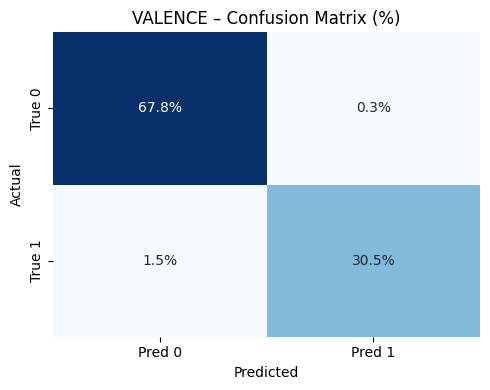

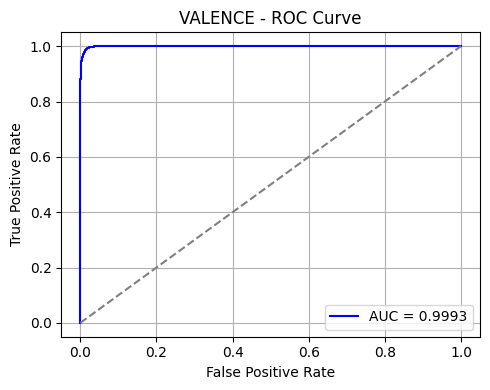

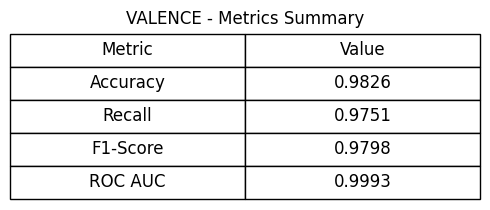

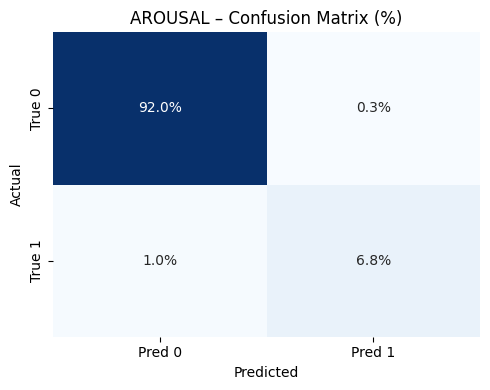

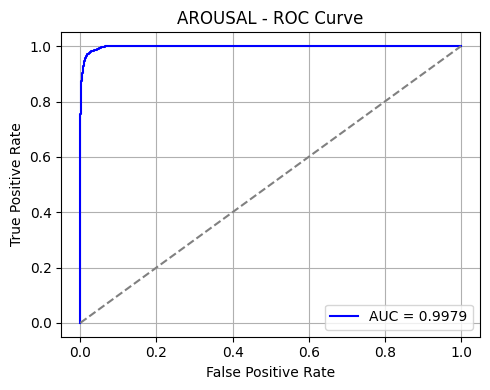

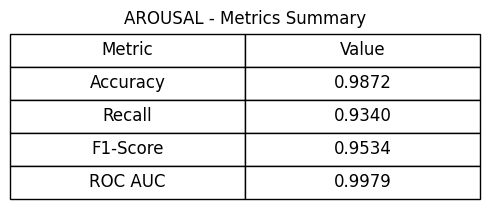

In [27]:
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Evaluación ===
model.eval()
model.to("cuda")

all_val_true, all_val_pred, all_val_proba = [], [], []
all_aro_true, all_aro_pred, all_aro_proba = [], [], []

with torch.no_grad():
    for batch in test_loader:
        inputs = {}
        i = 0
        if use_spatial:
            inputs['spatial'] = batch[i].cuda(); i += 1
        if connectivity_mode:
            inputs['connectivity'] = batch[i].cuda(); i += 1
        if use_intensity:
            inputs['intensity'] = batch[i].cuda(); i += 1

        label_val = batch[i].cuda(); i += 1
        label_aro = batch[i].cuda()

        pred_val, pred_aro = model(**inputs)

        probs_val = torch.softmax(pred_val, dim=1)[:, 1]
        probs_aro = torch.softmax(pred_aro, dim=1)[:, 1]

        preds_val = torch.argmax(pred_val, dim=1)
        preds_aro = torch.argmax(pred_aro, dim=1)

        all_val_true.extend(label_val.cpu().numpy())
        all_val_pred.extend(preds_val.cpu().numpy())
        all_val_proba.extend(probs_val.cpu().numpy())

        all_aro_true.extend(label_aro.cpu().numpy())
        all_aro_pred.extend(preds_aro.cpu().numpy())
        all_aro_proba.extend(probs_aro.cpu().numpy())

# ------------------------------------------------------------------
def mostrar_resultados_completos(y_true, y_pred, y_proba, title=""):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, average='macro')
    f1  = f1_score     (y_true, y_pred, average='macro')
    cm  = confusion_matrix(y_true, y_pred)

    # ---------- Matriz de confusión en porcentaje ----------
    total   = cm.sum()
    cm_pct  = cm / total * 100        # 0‑100 %
    
    # Etiquetas: valor absoluto + porcentaje (p.ej. “23\n(12.7%)”)
    labels = np.asarray(
        [[f"{cm_pct[i,j]:.1f}%" for j in range(cm.shape[1])]
         for i in range(cm.shape[0])]
    )

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_pct, annot=labels, fmt="", cmap="Blues", cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"{title.upper()} – Confusion Matrix (%)")
    plt.xlabel("Predicted");  plt.ylabel("Actual")
    plt.tight_layout();  plt.show()
    # --------------------------------------------------------

    # ---------- Curva ROC ----------
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="blue")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate");  plt.ylabel("True Positive Rate")
    plt.title(f"{title.upper()} - ROC Curve")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # ---------- Tabla resumen ----------
    fig, ax = plt.subplots(figsize=(5, 2.2))
    ax.axis("off")
    tbl = ax.table(
        cellText=[["Accuracy", f"{acc:.4f}"],
                  ["Recall",   f"{rec:.4f}"],
                  ["F1-Score", f"{f1:.4f}"],
                  ["ROC AUC",  f"{auc:.4f}"]],
        colLabels=["Metric", "Value"], cellLoc="center", loc="center")
    tbl.scale(1, 2); tbl.set_fontsize(12)
    plt.title(f"{title.upper()} - Metrics Summary")
    plt.tight_layout(); plt.show()
# ------------------------------------------------------------------

# === Mostrar métricas y visualizaciones ===
mostrar_resultados_completos(all_val_true, all_val_pred, all_val_proba, title="Valence")
mostrar_resultados_completos(all_aro_true, all_aro_pred, all_aro_proba, title="Arousal")
